# PyTorch: Aprendiendo Fashion-MNIST

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [189]:
# 1.0)
!pip3 install pandas scikit-learn scipy numpy matplotlib torch torchvision torchaudio torchviz


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [190]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [191]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [192]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [193]:
# 1.4)
# import google.colab
# from google.colab import files

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme (i.e. normalize los valores al rango [0,1]) los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Explore algunos ejemplos de estos conjuntos. Que formato poseen?

**3)** Visitando la página web de FashionMNIST, cree un diccionario de Python `Dict()` asociando cada categoría a un nombre adecuado de la misma.

**4)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

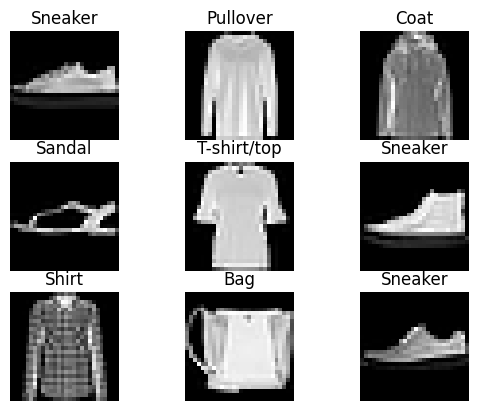

In [194]:
# 2.1)


class_map = {
    0:	"T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), 0.5,),
])

valid_set = datasets.FashionMNIST("MNIST_data/", download = True, train=False
, transform=transform
)

train_set = datasets.FashionMNIST("MNIST_data/", download = True, train=True
, transform=transform
)

# Preparo una figura con 6 Axes
ncols = 3
nrows = 3
fig, axes = plt.subplots(ncols=ncols, nrows=nrows)


for i in range(ncols * nrows):

    # Ejemplo random
    randindex = np.random.randint(0, len(train_set))
    image, classification = train_set[randindex]

    # Conseguir i-esimo subplot
    ax =  axes[i // ncols, i % ncols]

    ax.set_axis_off() # quitar ejes
    ax.imshow(image.squeeze(), cmap="gray") # mostrar imagen
    ax.set_title(class_map[classification]) # poner su clase como titulo



## Ejercicio 3)

Creando un `DataLoader` para alimentar el modelo con batchs (lotes) de entrenamiento.

**1)** Cree los `DataLoader`s para cada conjunto. Defínalos con un `batch_size` de 100 y con el flag `shuffle` seteado a `True`.

**2)** Use uno de los `DataLoader`s creados anteriormente para explorar algunos elementos del conjunto.

Notar que, el iterador devuelve el batch en un par `(image,label)`.

El objeto `images` es un tensor de dimensiones `(100,1,28,28)`.
El 100 es el tamaño del batch.
El 1 porque hay un solo canal (en este caso, un canal de escala de grises, pero podría haber varios, p. ej. uno por cada color de {Red, Green Blue} en caso que fuesen imagenes a color).
Luego, 28 y 28 porque cada imagen del dataset es de 28 x 28 píxeles.

El objeto `labels` es un tensor de dimensiones `(100,)`.
La $i$-ésima entrada `labels[i]` de `labels` es un número en $\{0,1,...,9\}$ indicando la categoría a la que pertenece la $i$-ésima imagen en el batch, guardada en `images[i]`.

In [195]:
# 3.1)

train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle=True)
valid_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle=False)

## Ejercicio 4)

Defina una red neuronal de 4 capas, una de entrada, dos ocultas de $n_1=128$ y $n_2=64$ neuronas, respectivamente, y una de salida de 10 neuronas.

En las capas intermedias utilice neuronas tipo ReLU y agregueles un *dropout* de p=0.2.
En la capa de salida no utilice funciones de activación ni dropout.

Las capas sucesivas tienen que estar totalmente conectadas entre si.

In [196]:
# 4)

class NN(nn.Module):
    
    p = .2
    
    def __init__(self):
        super().__init__()
        self.c0 = nn.Flatten()
        
        self.c1 = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=128),
            nn.ReLU(),
            nn.Dropout(self.p)
        )

        self.c2 = nn.Sequential(
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(self.p)
        )
        
        self.c3 = nn.Sequential(
            nn.Linear(in_features=64, out_features=10)
        )
        
        self.net = nn.Sequential(self.c0, self.c1, self.c2, self.c3)
    
    def forward(self, x):

        logits = self.net(x) 

        return logits

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device = torch.device(device)
print(f"Using {device} device")

model = NN().to(device)

# Pruebita:

image = torch.randn(1, 28, 28).to(device)

out = model(image)

probabilities = nn.Softmax(dim=1)(out)

print(f"{out= }")
print(f"{probabilities= }")
print(f"clasificacion= {probabilities.argmax(1)}")

Using cuda device
out= tensor([[-0.0035,  0.0592,  0.1072, -0.2224,  0.1782, -0.2726, -0.2720, -0.0904,
          0.2431, -0.1078]], device='cuda:0', grad_fn=<AddmmBackward0>)
probabilities= tensor([[0.1019, 0.1085, 0.1139, 0.0819, 0.1222, 0.0779, 0.0779, 0.0934, 0.1304,
         0.0918]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
clasificacion= tensor([8], device='cuda:0')


## Ejercicio 5)

Entrenamos el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` a partir del `train_set` (conjunto de entranmiento) y del `valid_set` (conjunto de validación) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando la **Cross Entropy Loss**.

**IMPORTANTE:** Notar que la **Cross Entropy Loss** aplica automáticamente una `log_softmax`.

**5)** Cree un optimizador que utilice el método de **Stochastic Gradient Descent** con un learning rate igual a $10^{-3}$.

**6)** Cree una instancia del modelo.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop de entrenamiento y validación que trabaje con el `train_loader` y el `valid_loader`, respectivamente, usando un numero arbitrario de épocas.
Este loop debe guardar en cuatro listas los valores de los promedios del **Cross Entropy Loss** y las fracciones de clasificaciones correctas o **precisión** (accuracy) sobre el conjunto de **entrenamiento** y el de **validación**, respectivamente.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso anterior para graficar en función de las épocas la **Cross Entropy Loss** de **entrenamiento** y de **validación**.
Realize un gráfico análogo pero con la **precisión**.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Repita los experimentos variando hiperparámetros. Por ejemplo:

- El learning-rate.
- El optimizador (ej. puede usar ADAM).
- El valor de dropout.
- El número de neuronas en las capas intermedias.
- El número de épocas de entrenamiento.
- El tamaño de los lotes.

Discuta los resultados.

In [209]:
# 5.1)

# ver https://stackoverflow.com/questions/65192475/pytorch-logsoftmax-vs-softmax-for-crossentropyloss
# para una discusion sobre logits, softmax, logsoftmax y cross entropy loss

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    # flag de entrenamiento, importante por las dropout layers
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss

        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()



def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



In [212]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 5


for epoch in range(epochs):
    train_loop(train_loader, model, loss_fn, optimizer)
    
    test_loop(valid_loader, model, loss_fn)




Test Error: 
 Accuracy: 71.6%, Avg loss: 0.890888 

Test Error: 
 Accuracy: 72.5%, Avg loss: 0.835920 

Test Error: 
 Accuracy: 73.4%, Avg loss: 0.794052 

Test Error: 
 Accuracy: 74.0%, Avg loss: 0.761022 

Test Error: 
 Accuracy: 74.4%, Avg loss: 0.734498 

